In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"
cmtes_csv = f"./data/CampaignFin{year}/cmtes{year}.txt"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name,name_new,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.086565e+09,868,1.251802e+06,612.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.179460e+08,582,5.462989e+05,2036.5
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,9.947018e+07,589,1.688798e+05,250.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,9.866908e+07,122,8.087629e+05,117035.5
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,9.195982e+07,197,4.668011e+05,500.0
5,,C00571703,CHEVRON CORPORATION,koch industries inc koch industries inc,Y4000,,NaN,NaN,WASHINGTON,TX,6.460129e+07,212,3.047231e+05,50000.0
6,,C00495028,CHC BOLD PAC,chc bold pac chc bold pac,Z9600,,NaN,NaN,WASHINGTON,DC,5.408387e+07,207,2.612747e+05,70000.0
7,,C00693382,FUND FOR POLICY REFORM,fund for policy reform fund for policy reform,J1200,,NaN,NaN,WILMINGTON,DE,4.950000e+07,7,7.071429e+06,6000000.0
8,,C00669259,FUTURE FORWARD USA ACTION,future forward usa action future forward usa a...,J1200,,NaN,NaN,WASHINGTON,DC,4.526326e+07,27,1.676417e+06,100000.0
9,,C00504530,AMERICAN ACTION NETWORK,american action network american action network,Z9600,,NaN,NaN,WASHINGTON,DC,4.465169e+07,138,3.235630e+05,100000.0


In [4]:
donors[donors["contrib_id"] == "q0002067764 "]

,contrib_id,recip_id,name,name_new,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation
8796,q0002067764,N00023864,"CHANDRA, SATISH",satish chandra,H1100,N,PHYSIAN,DOCTOR,NEW YORK,NY,52920.0,19,2785.263158,2772.0
18787,q0002067764,C00694323,"CHANDRA, SATISH",satish chandra,Z9600,N,PHYSIAN,SELF-EMPLOYED,NEW YORK,NY,30632.0,11,2784.727273,2772.0
2407465,q0002067764,N00001669,"CHANDRA, SATISH",satish chandra,H5100,N,PHYSICIAN,MADISON,NEW YORK,NY,525.0,3,175.000000,250.0


In [5]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
6211,P00013524,N00011042,Jo Jorgensen (L),L,PRES,,Y,Y,C,3L
6278,P00014209,N00042370,Don Blankenship (3),3,PRES,,Y,Y,C,3L
6934,P80000722,N00001669,Joe Biden (D),D,PRES,,Y,Y,C,DW
6936,P80001571,N00023864,Donald Trump (R),R,PRES,PRES,Y,Y,I,RL


In [6]:
lf = (
        pl.scan_csv(
            cmtes_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'cmte_id', 'pac_short', 'affiliate', 'pac', 
                        'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code', 
                        'source', 'sensitive', 'foreign', 'active'],
            ignore_errors=True
        )
        .select(['cmte_id', 'pac_short', 'affiliate', 'pac',
                 'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code',
                 'source', 'sensitive', 'foreign', 'active'])
    )
cmtes = lf.collect(streaming=True)
cmtes = cmtes.to_pandas()
cmtes[cmtes["party"] == "L"]

,cmte_id,pac_short,affiliate,pac,recip_id,recipcode,cand_id,party,prim_code,source,sensitive,foreign,active
1426,C00255695,Libertarian National Cmte,Libertarian Party,Libertarian Party,C00255695,3P,None,L,Z5300,Rept,n,0,1
1745,C00315713,Libertarian Party of Illinois,Libertarian Party,Libertarian Party,C00315713,3P,None,L,Z5300,Rept,N,0,1
1878,C00332221,Libertarian Assn of Massachusetts,Libertarian Party,Libertarian Party,C00332221,3P,None,L,Z5300,Rept,N,0,1
2649,C00399865,Libertarian Party of Virginia,Libertarian Party,Libertarian Party,C00399865,3P,None,L,Z5300,Rept,N,0,1
2658,C00400945,Libertarian Party of South Carolina,Libertarian Party,Libertarian Party,C00400945,3P,None,L,Z5300,Rept,n,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16745,C00758250,Liz Terwilliger for Congress,None,Liz Terwilliger for Congress,N00047569,3L,H0PA12207,L,Z1300,Rept,N,0,1
16861,C00759423,COMMITTEE TO ELECT TWHAMBY ...,None,None,C00759423,None,None,L,None,None,None,0,0
17029,C00761130,PRESTON NELSON FOR CONGRESS ...,None,None,N00042426,3L,H0IL08165,L,None,None,N,0,0
17181,C00762732,ITSBEAUTIME ...,None,None,N00047809,3N,P40004277,L,None,None,N,0,0


In [7]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Party                    1299587
Unknown                  1036328
Ideology/Single Issue     861610
Health                    541522
Finance                   443132
Tech                      224719
Law                       199207
Construction              122016
Transportation            118605
Labor                     112626
Energy                     89268
Agribusiness               73594
Manufacturing              55259
Defense                    37952
Name: count, dtype: int64

In [8]:
preds = pd.read_csv(pred_csv)
donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
donors = donors.merge(cands, on='recip_id', how='left')

In [9]:
donors = donors.merge(cmtes[
    ["cmte_id", "pac_short", "affiliate", "pac", "recip_id", "recipcode", "cand_id", "party"]], 
    left_on='recip_id', right_on="cmte_id", how='left', suffixes=[None, "_pac"]
    ).drop_duplicates(subset=['contrib_id', 'recip_id', 'cmte_id'], keep='last')

donors.loc[donors["pac"].notna(), "name_y"] = donors.loc[donors["pac"].notna(), "pac"]
donors.loc[donors["pac_short"].notna(), "name_y"] = donors.loc[donors["pac_short"].notna(), "pac_short"]

donors["recip_is_pac"] = False
donors.loc[donors["pac_short"].notna(), "recip_is_pac"] = True

donors.loc[donors["pac_short"].notna(), "party"] = donors.loc[donors["pac_short"].notna(), "party_pac"]

In [10]:
donors.loc[donors["name_y"] == "Stop Republicans PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Senate Majority PAC", "party"] = "D"
donors.loc[donors["name_y"] == "314 Action Fund", "party"] = "D"
donors.loc[donors["name_y"] == "Progressive Takeover", "party"] = "D"
donors.loc[donors["name_y"] == "Black Americans to Re-Elect the President", "party"] = "R"
donors.loc[donors["name_y"] == "National Victory Action Fund", "party"] = "R"
donors.loc[donors["name_y"] == "MeidasTouch", "party"] = "D"
donors.loc[donors["name_y"] == "Swing Left", "party"] = "D"
donors.loc[donors["name_y"] == "Democratic Strategy Institute", "party"] = "D"
donors.loc[donors["name_y"] == "Senate Leadership Fund", "party"] = "R"
donors.loc[donors["name_y"] == "America First Action", "party"] = "R"
donors.loc[donors["name_y"] == "Future Forward USA", "party"] = "D"
donors.loc[donors["name_y"] == "Unite the Country", "party"] = "D"
donors.loc[donors["name_y"] == "Need to Impeach", "party"] = "D"
donors.loc[donors["name_y"] == "Tech for Campaigns", "party"] = "D"
donors.loc[donors["name_y"] == "Georgia Honor", "party"] = "D"
donors.loc[donors["name_y"] == "The Georgia Way", "party"] = "D"
donors.loc[donors["name_y"] == "Citizens for Free Enterprise", "party"] = "R"
donors.loc[donors["name_y"] == "Tom Steyer PAC", "party"] = "D"
donors.loc[donors["name_y"] == "GOPAC", "party"] = "R"
donors.loc[donors["name_y"] == "LMG PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Democratic Majority for Israel", "party"] = "D"
donors.loc[donors["name_y"] == "Plains PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Future Now Fund PAC", "party"] = "D"
donors.loc[donors["name_y"] == "House Freedom Action", "party"] = "R"
donors.loc[donors["name_y"] == "Way to Lead PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Better Future Michigan Fund", "party"] = "R"
donors.loc[donors["name_y"] == "Digidems PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Justice & Public Safety", "party"] = "D"
donors.loc[donors["name_y"] == "Casa in Action PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Conservative Outsider PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Save America Fund", "party"] = "D"
donors.loc[donors["name_y"] == "People Standing Strong", "party"] = "D"
donors.loc[donors["name_y"] == "State Government Citizens' Campaign", "party"] = "D"
donors.loc[donors["name_y"] == "Mind the Gap", "party"] = "D"
donors.loc[donors["name_y"] == "Elect Democratic Women", "party"] = "D"
donors.loc[donors["name_y"] == "Everyday People PAC", "party"] = "D"
donors.loc[donors["name_y"] == "For Our Families PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Save the US Senate PAC", "party"] = "R"
donors.loc[donors["name_y"] == "One Vote at a Time", "party"] = "D"
donors.loc[donors["name_y"] == "Humanity Forward Fund", "party"] = "D"
donors.loc[donors["name_y"] == "One Vote at a Time", "party"] = "D"
donors.loc[donors["name_y"] == "American Patriots PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Virginia Plus PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Valor America", "party"] = "R"
donors.loc[donors["name_y"] == "United We Win", "party"] = "D"
donors.loc[donors["name_y"] == "New South Super PAC", "party"] = "D"
donors.loc[donors["name_y"] == "March On PAC", "party"] = "D"
donors.loc[donors["name_y"] == "L PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Louisiana Legacy PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Our Future United", "party"] = "D"
donors.loc[donors["name_y"] == "New American Jobs Fund", "party"] = "D"
donors.loc[donors["name_y"] == "Patriots of America PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Sister District Project", "party"] = "D"
donors.loc[donors["name_y"] == "Abolitionists PAC", "party"] = "D"
donors.loc[donors["name_y"] == "California Democracy Ventures Fund", "party"] = "D"
donors.loc[donors["name_y"] == "WinRed", "party"] = "R"

In [11]:
donors.groupby(["name_y", "party"])["total_donated"].sum().sort_values(ascending=False)[:10]

name_y                               party
Michael Bloomberg (D)                D        1.086629e+09
WinRed                               R        7.205965e+08
Joe Biden (D)                        D        6.818375e+08
Donald Trump (R)                     R        4.763821e+08
Republican National Cmte             R        4.361667e+08
Biden Victory Fund                   D        3.860870e+08
Trump Make America Great Again Cmte  R        3.667061e+08
Trump Victory                        R        3.418192e+08
DNC Services Corp                    D        3.291139e+08
Tom Steyer (D)                       D        3.202495e+08
Name: total_donated, dtype: float64

In [12]:
contrib_party_totals = (
    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
    .sum()
    .unstack()
    .fillna(0)
)

contrib_party_totals['dem_ratio'] = (
    contrib_party_totals.get('D', 0) / 
    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
)

donors = donors.merge(
    contrib_party_totals['dem_ratio'].reset_index(),
    on=['contrib_id', 'name_new'],
    how='left'
)

donors

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,cmte_id,pac_short,affiliate,pac,recip_id_pac,recipcode_pac,cand_id,party_pac,recip_is_pac,dem_ratio
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,...,C00484642,Senate Majority PAC,Senate Majority PAC,Senate Majority PAC,C00484642,OI,None,,True,1.0
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,...,C00618371,Trump Make America Great Again Cmte,None,Trump Make America Great Again Cmte,C00618371,RP,None,R,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7136231,h3001209792,N00040675,"GOULD, COLIN",colin gould,C5120,M,SOFTWARE INFRASTRUCTURE ARCHITECT,ORACLE,FOSTER CITY,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0
7136232,p0001372401,C00003418,"BLEDSOE, PEARLIOUS MS",pearlious ms bledsoe,X1200,F,RETIRED,RETIRED,GRANITEVILLE,SC,...,C00003418,Republican National Cmte,Republican National Cmte,Republican National Cmte,C00003418,RP,None,R,True,0.0
7136233,r0006423692,C00003418,"CARMICHAEL, RUTH",ruth carmichael,X1200,F,RETIRED,RETIRED,KANSAS CITY,KS,...,C00003418,Republican National Cmte,Republican National Cmte,Republican National Cmte,C00003418,RP,None,R,True,0.0
7136234,r0015995400,C00003418,"BOOKATZ, DEBRA MRS",debra mrs bookatz,Y4000,F,RETIRED,MARINE CORP. COMMUNITY SERVICES,KANEOHE,HI,...,C00003418,Republican National Cmte,Republican National Cmte,Republican National Cmte,C00003418,RP,None,R,True,0.0


In [13]:
donors[~(donors["name_y"].isna())].sort_values(by=['total_donated'], ascending=False).iloc[:10][["name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
0,michael r bloomberg,Z9000,M,FOUNDER,NEW YORK,NY,1.086565e+09,Michael Bloomberg (D),D,PRES,C,DL
1,tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SAN FRANCISCO,CA,3.179460e+08,Tom Steyer (D),D,PRES,C,DL
2,information information requested,Y4000,,NaN,NEW YORK,CA,9.947018e+07,Joe Biden (D),D,PRES,C,DW
3,majority forward majority forward,Z9600,,NaN,WASHINGTON,DC,9.866908e+07,Senate Majority PAC,D,NaN,NaN,NaN
4,winred winred,Z9600,,NaN,ARLINGTON,VA,9.195982e+07,Trump Make America Great Again Cmte,R,NaN,NaN,NaN
5,koch industries inc koch industries inc,Y4000,,NaN,WASHINGTON,TX,6.460129e+07,Senate Leadership Fund,R,NaN,NaN,NaN
6,chc bold pac chc bold pac,Z9600,,NaN,WASHINGTON,DC,5.408387e+07,House Majority PAC,None,NaN,NaN,NaN
7,fund for policy reform fund for policy reform,J1200,,NaN,WILMINGTON,DE,4.950000e+07,Democracy PAC ...,None,NaN,NaN,NaN
8,future forward usa action future forward usa a...,J1200,,NaN,WASHINGTON,DC,4.526326e+07,Future Forward USA,D,NaN,NaN,NaN
9,american action network american action network,Z9600,,NaN,WASHINGTON,DC,4.465169e+07,Congressional Leadership Fund,None,NaN,NaN,NaN


In [14]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
277,h3003465387,shiva ayyadurai,Z9000,U,CHAIRMAN & CEO,BELMONT,MA,1044900.0,Shiva Ayyadurai (R),R,MAS2,C,RL
334,U00000033011,vinod khosla,F2500,M,FOUNDER,SAN JOSE,CA,1000000.0,American Bridge 21st Century,None,NaN,NaN,NaN
311,U0000004761,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,SAN FRANCISCO,CA,1000000.0,Future Forward USA,D,NaN,NaN,NaN
327,U00000033011,vinod khosla,F2500,M,VENTURE CAPITALIST,MENLO PARK,CA,1000000.0,Senate Majority PAC,D,NaN,NaN,NaN
493,h10013502001,prem reddy,Z9600,M,FOUNDER/CHIEF EXECUTIVE OFFICER,VICTORVILLE,CA,721300.0,Biden Victory Fund,D,NaN,NaN,NaN
589,U0000004388A,padmaja mrs mantena,H3900,F,HOMEMAKER,JUPITER,FL,625000.0,Trump Victory,R,NaN,NaN,NaN
590,p00053429381,ramalinga mantena,H3900,F,SELF-EMPLOYED,JUPITER,FL,625000.0,Trump Victory,R,NaN,NaN,NaN
612,m0001327150,sameer gandhi,F2500,M,VENTURE CAPITALIST,SAN FRANCISCO,CA,605600.0,Biden Victory Fund,D,NaN,NaN,NaN
1037,i30032161751,nachhattar chandi,F4100,M,OWNER,INDIO,CA,410000.0,Trump Victory,R,NaN,NaN,NaN
1085,h3001220400,nirmal mulye,Z9600,M,CHAIRMAN,MIAMI,FL,399500.0,WinRed,R,NaN,NaN,NaN


In [15]:
donors[(donors["recip_is_pac"] == False)].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
D    1223
R    1187
I      62
3      37
L      36
U       2
Name: count, dtype: int64

In [16]:
donors[(donors["ethnic"] == "ind") & (donors["recip_is_pac"] == False)].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
D    567
R    392
I      6
L      3
3      2
Name: count, dtype: int64

In [17]:
donors[(donors["ethnic"] == "ind") & (donors["recip_is_pac"] == True)].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
D    264
R    156
     149
3      2
L      1
Name: count, dtype: int64

In [18]:
donors[donors["ethnic"] == "ind"].groupby("party")["total_donated"].sum().sort_values(ascending=False)

party
D    51892411.0
R    20013777.0
I     1238649.0
       720273.0
L        2554.0
3        1070.0
Name: total_donated, dtype: float64

In [19]:
donors[(donors["ethnic"] == "ind") & (donors["recip_is_pac"] == False)].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')[["recip_id", "name_y", "party", "seat"]]

,recip_id,name_y,party,seat
51249,N00041312,Omar Siddiqui (D),D,CA48
96273,N00038290,Jan McDowell (D),D,TX24
126142,N00031005,Vicky Hartzler (R),R,MO04
130450,N00045057,Beth Parlato (R),R,NY27
131516,N00037442,Neal Dunn (R),R,FL02
...,...,...,...,...
7134309,N00043581,Ilhan Omar (D),D,MN05
7134391,N00041334,Theresa Greenfield (D),D,IAS2
7134921,N00046489,Raphael Warnock (D),D,GAS2
7135495,N00040675,Jon Ossoff (D),D,GAS1


In [20]:
donors[(donors["ethnic"] == "ind") & (donors["recip_is_pac"] == False) & (donors["state"] == "WY")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
19745,p0005411243,farid khan,Y4000,M,HOTELIER,GILLETTE,WY,29500.0,Donald Trump (R),R,PRES,I,RL
264289,m00014288021,king husein,B1500,M,CHAIRMAN,JACKSON,WY,5600.0,Donald Trump (R),R,PRES,I,RL
567687,m00014288021,king mr husein,B1500,M,CHAIRMAN AND CEO,JACKSON,WY,2800.0,Liz Cheney (R),R,WY01,I,RW
587609,m00014288021,king husein,B4400,M,ENGINEER,JACKSON,WY,2800.0,Kelly Loeffler (R),R,GAS2,I,RL
594568,m0001428802@,diane mrs husein,Y4000,F,SECRETARY,JACKSON,WY,2800.0,Liz Cheney (R),R,WY01,I,RW
609180,r0014730623,dharmesh patel,Y3000,M,SELF EMPLOYED,SHERIDAN,WY,2800.0,Joe Biden (D),D,PRES,C,DW
611339,m0001428802@,diane husein,Y4000,F,SECRETARY,JACKSON,WY,2800.0,Kelly Loeffler (R),R,GAS2,I,RL
615020,m0001428802@,diane husein,Y4000,F,SECRETARY,JACKSON,WY,2800.0,David Perdue (R),R,GAS1,I,RL
633976,m00014288021,king husein,B4400,M,ENGINEER,JACKSON,WY,2800.0,David Perdue (R),R,GAS1,I,RL
4460550,m00014288021,king husein,B1500,M,FOUNDER / CEO,JACKSON,WY,250.0,TJ Cox (D),D,CA21,I,DL


In [21]:
# 2020: 5.8 billion vs 38.5 million not counting PACs
# 2020: 12 billion vs 80.9 million counting PACs
print("Overall:", donors["total_donated"].sum())
print("Indians:", donors[(donors["ethnic"] == "ind")]["total_donated"].sum())

Overall: 12004197961.0
Indians: 80911468.0


In [22]:
print("Finance:", donors[(donors["sector"] == "Finance")]["total_donated"].sum())
print("Finance, Indian:", donors[(donors["sector"] == "Finance") & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Tech:", donors[(donors["sector"] == "Tech")]["total_donated"].sum())
print("Tech, Indian:", donors[(donors["sector"] == "Tech") & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Health:", donors[(donors["sector"] == "Health")]["total_donated"].sum())
print("Healthm Indian:", donors[(donors["sector"] == "Health") & (donors["ethnic"] == "ind")]["total_donated"].sum())

Finance: 1655705510.0
Finance, Indian: 16630991.0
Tech: 438847125.0
Tech, Indian: 4673204.0
Health: 605109127.0
Healthm Indian: 11385300.0


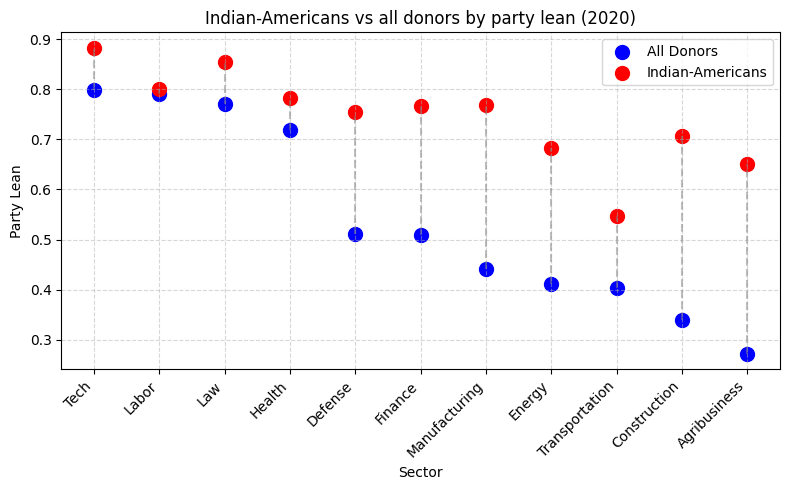

In [23]:
mean_all = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all.index
mean_ind = mean_ind.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, mean_all, mean_ind):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, mean_all, color='blue', label='All Donors', s=100)
plt.scatter(sectors, mean_ind, color='red', label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs all donors by party lean (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
# statistical tests

model = ols('dem_ratio ~ C(ethnic) + C(sector)', data=donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq        df            F        PR(>F)
C(ethnic)      87.661048       1.0   419.776334  2.923498e-93
C(sector)   17587.906298      10.0  8422.197741  0.000000e+00
Residual   134772.364373  645375.0          NaN           NaN


In [25]:
tukey = pairwise_tukeyhsd(endog=donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["dem_ratio"].notnull())]['dem_ratio'],
                         groups=donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["dem_ratio"].notnull())]['ethnic'],
                         alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   ind    not  -0.2438   0.0 -0.2553 -0.2323   True
---------------------------------------------------


In [26]:
state_stats = (
    donors.groupby(["state", "party"])
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].mean()),
        med_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].median()),
        total_donations_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].sum()),
        donor_count_indian=("ethnic", lambda x: (x == "ind").sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,party,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian
0,NY,D,5370.537691,500.0,1.656156e+09,308378,2331.266146,754.5,6569508.0,2818
1,CA,D,2245.844363,500.0,1.415183e+09,630134,2731.893233,500.0,16631766.0,6088
2,TX,R,1798.263274,375.0,5.567855e+08,309624,2194.571429,500.0,1812716.0,826
3,CA,R,1553.551169,300.0,5.448925e+08,350740,3047.264163,500.0,4625747.0,1518
4,FL,R,1707.382290,332.0,4.515326e+08,264459,5474.376116,662.0,4905041.0,896
5,DC,D,3970.459108,500.0,2.921623e+08,73584,1262.413793,500.0,658980.0,522
6,NY,R,2233.707970,332.0,2.502646e+08,112040,1888.983553,500.0,1148502.0,608
7,MA,D,1543.772488,500.0,2.445614e+08,158418,3121.663227,750.0,3327693.0,1066
8,VA,R,2421.305543,375.0,2.175616e+08,89853,954.293388,500.0,230939.0,242
9,TX,D,1164.975863,388.0,1.775680e+08,152422,1899.775333,500.0,3280912.0,1727


In [27]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [28]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [29]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

In [30]:
gdf_merged.to_file("../backend/state_stats.geojson", driver="GeoJSON")

In [31]:
state_pivot = state_stats.pivot(index='state', columns='party', values='total_donations').fillna(0)
state_pivot['total'] = state_pivot['D'] + state_pivot['R']
state_pivot['dem_ratio'] = state_pivot['D'] / state_pivot['total']

state_pivot_indian = state_stats.pivot(index='state', columns='party', values='total_donations_indian').fillna(0)
state_pivot_indian['total'] = state_pivot_indian['D'] + state_pivot_indian['R']
state_pivot_indian['dem_ratio'] = state_pivot_indian['D'] / state_pivot_indian['total']

ratio = gdf.merge(state_pivot, left_on='state', right_index=True, how='left')
ratio_indian = gdf.merge(state_pivot_indian, left_on='state', right_index=True, how='left')


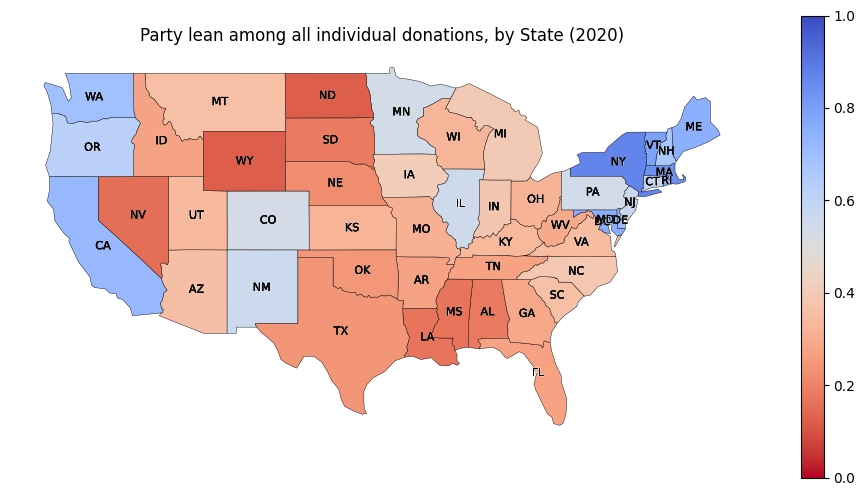

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio.plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among all individual donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [33]:
ratio[["state", "total"]].sort_values(by="total", ascending=False).head(10)

,state,total
7,CA,1.960075e+09
46,NY,1.906420e+09
22,TX,7.343534e+08
29,FL,6.193604e+08
39,VA,3.343914e+08
43,DC,3.286131e+08
24,MA,2.916030e+08
33,IL,2.797371e+08
30,GA,2.081212e+08
5,WA,2.002888e+08


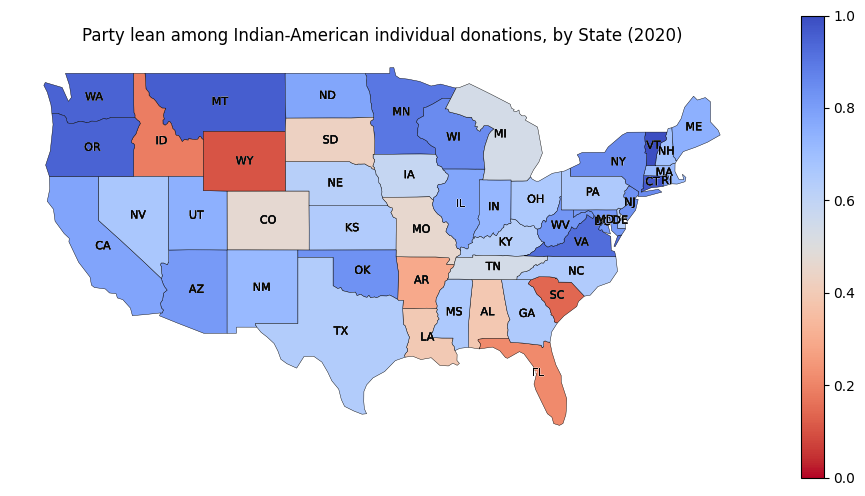

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio_indian.plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-American individual donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [35]:
ratio_indian[["state", "total", "dem_ratio"]].sort_values(by="total", ascending=False).iloc[40:]

,state,total,dem_ratio
41,WV,45518.0,0.821411
18,NE,41930.0,0.625423
14,AR,40018.0,0.289395
48,ME,20095.0,0.747599
27,VT,12845.0,0.992371
4,ID,11559.0,0.187473
1,MT,10069.0,0.960373
20,SD,5151.0,0.429431
2,ND,1615.0,0.780186


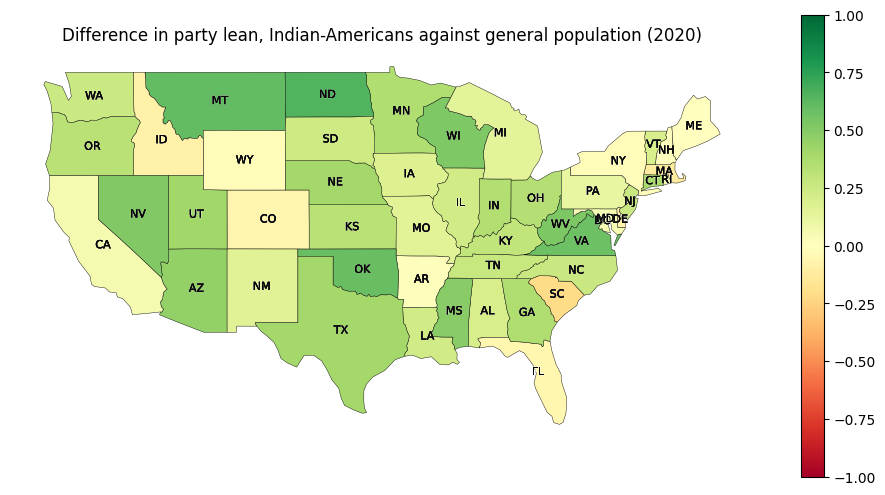

In [36]:
ratio["diff"] = ratio_indian["dem_ratio"] - ratio["dem_ratio"]

fig, ax = plt.subplots(figsize=(12, 6))
ratio.plot(
    column="diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in party lean, Indian-Americans against general population (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [37]:
sector_stats = (
    donors[~(donors["sector"].isin(["Ideology/Single Issue", "Party", "Unknown"]))].groupby(["state", "sector", "party"])["total_donated"]
    .sum()
    .unstack()
    .fillna(0)
)
sector_stats["total_donated"] = sector_stats["D"] + sector_stats["R"]
sector_stats["dem_ratio"] = sector_stats["D"] / (sector_stats["D"] + sector_stats["R"])
sector_stats = sector_stats.sort_values(by="total_donated", ascending=False).reset_index()
sector_stats

party,state,sector,,3,D,I,L,R,U,d,total_donated,dem_ratio
0,CA,Finance,7361273.0,12028.0,143902794.0,959027.0,58939.0,117514158.0,0.0,0.0,261416952.0,0.550472
1,NY,Finance,2536362.0,15414.0,139917314.0,676769.0,24401.0,105732071.0,0.0,2500.0,245649385.0,0.569581
2,CA,Tech,3638725.0,27932.0,149113405.0,3863769.0,38567.0,14085224.0,0.0,2000.0,163198629.0,0.913693
3,FL,Finance,1157469.0,4300.0,26497893.0,189955.0,24504.0,75034086.0,0.0,0.0,101531979.0,0.260981
4,TX,Finance,1295490.0,750.0,15191018.0,322605.0,42578.0,75829124.0,0.0,0.0,91020142.0,0.166897
...,...,...,...,...,...,...,...,...,...,...,...,...
636,AP,Tech,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.000000
637,AP,Transportation,0.0,0.0,0.0,189.0,0.0,0.0,0.0,0.0,0.0,NaN
638,MP,Finance,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,NaN
639,AS,Law,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,NaN


In [38]:
sector_stats_indian = (
    donors[~(donors["sector"].isin(["Ideology/Single Issue", "Party", "Unknown"])) & (donors["ethnic"] == "ind")].groupby(["state", "sector", "party"])["total_donated"]
    .sum()
    .unstack()
    .fillna(0)
)
sector_stats_indian["total_donated"] = sector_stats_indian["D"] + sector_stats_indian["R"]
sector_stats_indian["dem_ratio"] = sector_stats_indian["D"] / (sector_stats_indian["D"] + sector_stats_indian["R"])
sector_stats_indian = sector_stats_indian.sort_values(by="total_donated", ascending=False).reset_index()
sector_stats_indian.iloc[:10]

party,state,sector,,3,D,I,L,R,total_donated,dem_ratio
0,CA,Finance,94066.0,500.0,5922889.0,8362.0,250.0,2169206.0,8092095.0,0.731935
1,FL,Health,7153.0,0.0,121269.0,7267.0,245.0,3084054.0,3205323.0,0.037834
2,CA,Health,3889.0,0.0,2221996.0,59095.0,0.0,405710.0,2627706.0,0.845603
3,NY,Finance,2341.0,0.0,2174282.0,1578.0,0.0,211887.0,2386169.0,0.911202
4,MA,Tech,10500.0,0.0,1303699.0,1903.0,0.0,4000.0,1307699.0,0.996941
5,NJ,Finance,2571.0,0.0,1124822.0,467.0,0.0,77995.0,1202817.0,0.935156
6,CA,Tech,24442.0,0.0,758979.0,61838.0,0.0,330456.0,1089435.0,0.696672
7,IL,Finance,900.0,0.0,536850.0,6971.0,0.0,287989.0,824839.0,0.650854
8,NY,Health,620.0,0.0,462309.0,20122.0,25.0,293504.0,755813.0,0.611671
9,WA,Tech,17024.0,0.0,711154.0,13275.0,0.0,7125.0,718279.0,0.990080


In [52]:
sector_stats_indian[sector_stats_indian["state"] == "FL"]["total_donated"].sum()

3735907.0

In [40]:
sector_stats_indian[sector_stats_indian["sector"].isin(["Finance", "Tech"])].iloc[:10]

party,state,sector,,3,D,I,L,R,total_donated,dem_ratio
0,CA,Finance,94066.0,500.0,5922889.0,8362.0,250.0,2169206.0,8092095.0,0.731935
3,NY,Finance,2341.0,0.0,2174282.0,1578.0,0.0,211887.0,2386169.0,0.911202
4,MA,Tech,10500.0,0.0,1303699.0,1903.0,0.0,4000.0,1307699.0,0.996941
5,NJ,Finance,2571.0,0.0,1124822.0,467.0,0.0,77995.0,1202817.0,0.935156
6,CA,Tech,24442.0,0.0,758979.0,61838.0,0.0,330456.0,1089435.0,0.696672
7,IL,Finance,900.0,0.0,536850.0,6971.0,0.0,287989.0,824839.0,0.650854
9,WA,Tech,17024.0,0.0,711154.0,13275.0,0.0,7125.0,718279.0,0.990080
12,CT,Finance,8948.0,0.0,521498.0,0.0,0.0,6325.0,527823.0,0.988017
16,VA,Finance,925.0,0.0,328800.0,66.0,0.0,5136.0,333936.0,0.984620
20,TX,Finance,5853.0,0.0,96393.0,4048.0,0.0,179020.0,275413.0,0.349994


In [41]:
sector_stats_indian[sector_stats_indian["sector"].isin(["Agribusiness"])].iloc[:10]

party,state,sector,,3,D,I,L,R,total_donated,dem_ratio
29,NY,Agribusiness,0.0,0.0,152388.0,0.0,0.0,0.0,152388.0,1.000000
62,CA,Agribusiness,832.0,0.0,27527.0,0.0,0.0,27235.0,54762.0,0.502666
152,TX,Agribusiness,0.0,0.0,7570.0,0.0,0.0,0.0,7570.0,1.000000
174,MA,Agribusiness,0.0,0.0,4759.0,0.0,0.0,0.0,4759.0,1.000000
177,MD,Agribusiness,0.0,0.0,250.0,0.0,0.0,4397.0,4647.0,0.053798
208,IN,Agribusiness,0.0,0.0,2745.0,0.0,0.0,0.0,2745.0,1.000000
213,IL,Agribusiness,0.0,0.0,2000.0,0.0,0.0,500.0,2500.0,0.800000
226,WA,Agribusiness,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0.000000
250,OH,Agribusiness,0.0,0.0,195.0,0.0,0.0,875.0,1070.0,0.182243
252,FL,Agribusiness,0.0,0.0,0.0,0.0,0.0,1000.0,1000.0,0.000000


In [77]:
donors[(donors["ethnic"] == "ind") & (donors["state"] == "FL") & ~(donors["contrib_id"].isin(["U0000004388A", "p00053429381", "h3001220400 "]))]["dem_ratio"].mean()

0.5040491652178037

In [70]:
donors[(donors["ethnic"] == "ind") & (donors["state"] == "WY") & (donors["contrib_id"].isin(["m00014288021", "m0001428802@", "p0005411243 "]))]["total_donated"].sum()

177550.0

In [74]:
donors[(donors["ethnic"] == "ind") & (donors["state"] == "WY")]["total_donated"].sum()

200571.0

In [48]:
donors[(donors["state"] == "NY") & (donors["sector"].isin(["Agribusiness"]))].iloc[10:20].sort_values(by="total_donated", ascending=False)[["contrib_id", "name_new", "occupation", "employer", "sector", "city", "state", "name_y", "pac_short", "total_donated", "dem_ratio"]]

,contrib_id,name_new,occupation,employer,sector,city,state,name_y,pac_short,total_donated,dem_ratio
31581,b00606179841,howard lorber,PRESIDENT & CEO,VECTOR GROUP LTD,Agribusiness,NEW YORK,NY,The Victory Club,The Victory Club,19600.0,0.0
32073,b06084114241,wesley r edens,CHAIRMAN,FORTRESS INVESTMENT GROUP,Agribusiness,NEW YORK,NY,National Republican Senatorial Cmte,National Republican Senatorial Cmte,19400.0,0.0
49573,p0005391892,tim rice,VET,SELF-EMPLOYED,Agribusiness,STOW,NY,Donald Trump (R),NaN,12300.0,0.0
53395,r0017054229,peter harbes,FARMER,SELF-EMPLOYED,Agribusiness,CALVERTON,NY,Donald Trump (R),NaN,11400.0,0.0
53518,U0000004765A,katrina costello,NaN,NaN,Agribusiness,ASTORIA,NY,Nobody Leaves Mid-Hudson Action,Nobody Leaves Mid-Hudson Action,11357.0,1.0
56831,b90601197482,monica mccourt,EQUESTRIAN,SELF EMPLOYED,Agribusiness,NEW YORK,NY,Joe Kennedy III (D),NaN,11200.0,1.0
67044,d0000794341,george mr kramer,VETERINARIAN,ACVS,Agribusiness,BOHEMIA,NY,National Republican Congressional Cmte,National Republican Congressional Cmte,11000.0,0.0
71914,n00014193631,dee hensen,VETERINARIAN,PAUMANOK VETERINARY HOSPITAL,Agribusiness,MILLER PLACE,NY,Biden Victory Fund,Biden Victory Fund,10271.0,1.0
76946,d0000794341,george kramer,VETERINARIAN,ACVS,Agribusiness,MANORVILLE,NY,Zeldin Victory Cmte 2020,Zeldin Victory Cmte 2020,10000.0,0.0
79859,U00000045361,jack c bendheim,CHAIRMAN,PHIBRO-TECH INC,Agribusiness,RIVERDALE,NY,New Jersey Democratic State Cmte,New Jersey Democratic State Cmte,10000.0,1.0


In [57]:
ratio_indian[ratio_indian["state"] == "WY"]

,iso_3166_2,name,geometry,state,,3,D,I,L,R,U,d,total,dem_ratio
13,US-WY,Wyoming,"POLYGON ((-111.08518 44.50615, -111.06719 44.5...",WY,0.0,0.0,20630.0,77.0,0.0,178582.0,0.0,0.0,199212.0,0.103558
